# Build a chatting assistant for SQL data


Developing a conversational assistant for structured datasets involves a distinct approach compared to handling unstructured text data. While unstructured data often leverages vector search for generating responses, working with structured data typically involves constructing and executing queries in a domain-specific language like SQL. In this task, we will explore how to create a Q&A system tailored for structured procurement data, leveraging techniques that allow an AI-driven conversational interface to retrieve and interpret relevant insights from a tabular dataset. The goal is to build a prototype capable of handling user queries effectively.

## Security note 

Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your chain/agent's needs. This will mitigate though not eliminate the risks of building a model-driven system


## Architecture

At a high-level, the steps of these systems are:

1. **Convert question to SQL query**: Model converts user input to a SQL query.
2. **Execute SQL query**: Execute the query.
3. **Answer the question**: Model responds to user input using the query results.

## Setup

First, get required packages and set environment variables:

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langgraph

# Preprocessing and Conversion of Procurement Dataset to SQLite Database

This section preprocesses the procurement dataset and converts it into an SQLite database.

### Steps:
1. **Load the dataset:** Read the dataset from a CSV file into a Pandas DataFrame.
2. **Handle missing values:** Fill missing values in critical columns (`Unit Price` and `Total Price`) with zero.
3. **Format price columns:** Convert price-related columns from string format (e.g., "$123.45") to numerical format for calculations.
4. **Rename columns:** Replace spaces and hyphens in column names with underscores to ensure compatibility with SQL.
5. **Convert date columns:** Transform `Creation Date` and `Purchase Date` into datetime objects for date-based queries.
6. **Feature extraction:** Derive additional columns:
   - Day, month, year, and quarter from the `Creation Date` and `Purchase Date` columns for simplified temporal analysis.
7. **Save to SQLite database:** Store the cleaned and enriched DataFrame as a table in an SQLite database (`consumption.db`).

### Purpose:
The resulting SQLite database will be utilized with LangChain to develop a conversational AI system capable of querying and analyzing procurement data.


In [ ]:
import sqlite3
import pandas as pd 

df = pd.read_csv("PURCHASE ORDER DATA EXTRACT 2012-2015_0.csv")
df["Unit Price"].fillna(0, inplace=True)
df["Total Price"].fillna(0, inplace=True)

df["Unit Price"] = df["Unit Price"].apply(lambda x: float(x[1:] if x else x))
df["Total Price"] = df["Total Price"].apply(lambda x: float(x[1:] if x else x))

df.columns = [c.replace(" ", "_") for c in df.columns]
df.columns = [c.replace("-", "_") for c in df.columns]

# Convert dates to datetime objects
df['Creation_Date'] = pd.to_datetime(df['Creation_Date'], format='%m/%d/%Y', errors='coerce')
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], format='%m/%d/%Y', errors='coerce')

# Extract day, month, and year from Creation_Date
df['Creation_Date_Day'] = df['Creation_Date'].dt.day
df['Creation_Date_Month'] = df['Creation_Date'].dt.month
df['Creation_Date_Year'] = df['Creation_Date'].dt.year
df['Creation_Date_Quarter'] = df['Creation_Date'].dt.to_period('Q').astype(str)

# Extract day, month, and year from Purchase_Date
df['Purchase_Date_Day'] = df['Purchase_Date'].dt.day
df['Purchase_Date_Month'] = df['Purchase_Date'].dt.month
df['Purchase_Date_Year'] = df['Purchase_Date'].dt.year
df['Purchase_Date_Quarter'] = df['Creation_Date'].dt.to_period('Q').astype(str)

conn = sqlite3.connect('consumption.db',check_same_thread=False)

df.to_sql('consumption', conn, index=False, if_exists='replace')

346018

# Connecting to the SQLite Database with LangChain

This section establishes a connection to the SQLite database (`consumption.db`) using LangChain's `SQLDatabase` utility.

### Steps:
1. **Import SQLDatabase utility:** Leverage the `SQLDatabase` class from the LangChain community package.
2. **Connect to the database:** Specify the URI of the SQLite database (`sqlite:///consumption.db`) to create an instance of `SQLDatabase`.
3. **Inspect the database:**
   - Print the SQL dialect used by the database (e.g., `sqlite`).
   - Retrieve and display the names of usable tables in the database.
   - Fetch and print detailed metadata about the tables to understand their structure.

This setup ensures that the database connection is ready for querying and further integration with the LangChain system.


In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///consumption.db")
print(db.dialect)
print(db.get_usable_table_names())
print(db.get_table_info())


sqlite
['consumption']

CREATE TABLE consumption (
	"Creation_Date" TIMESTAMP, 
	"Purchase_Date" TIMESTAMP, 
	"Fiscal_Year" TEXT, 
	"LPA_Number" TEXT, 
	"Purchase_Order_Number" TEXT, 
	"Requisition_Number" TEXT, 
	"Acquisition_Type" TEXT, 
	"Sub_Acquisition_Type" TEXT, 
	"Acquisition_Method" TEXT, 
	"Sub_Acquisition_Method" TEXT, 
	"Department_Name" TEXT, 
	"Supplier_Code" REAL, 
	"Supplier_Name" TEXT, 
	"Supplier_Qualifications" TEXT, 
	"Supplier_Zip_Code" TEXT, 
	"CalCard" TEXT, 
	"Item_Name" TEXT, 
	"Item_Description" TEXT, 
	"Quantity" REAL, 
	"Unit_Price" REAL, 
	"Total_Price" REAL, 
	"Classification_Codes" TEXT, 
	"Normalized_UNSPSC" REAL, 
	"Commodity_Title" TEXT, 
	"Class" REAL, 
	"Class_Title" TEXT, 
	"Family" REAL, 
	"Family_Title" TEXT, 
	"Segment" REAL, 
	"Segment_Title" TEXT, 
	"Location" TEXT, 
	"Creation_Date_Day" INTEGER, 
	"Creation_Date_Month" INTEGER, 
	"Creation_Date_Year" INTEGER, 
	"Creation_Date_Quarter" TEXT, 
	"Purchase_Date_Day" REAL, 
	"Purchase_Date_Month" R

Great! We've got a SQL database that we can query. Now let's try hooking it up to an LLM.

# Hooking the SQL Database to an LLM using Chains

In this section, we begin integrating the SQL database with a Large Language Model (LLM) to create a system that answers user queries by leveraging structured data.

### Overview of Chains
Chains represent a sequence of predictable steps to process input and generate output. In LangGraph, a chain is modeled as a simple sequence of interconnected nodes. 

For this task, the chain will:
1. **Convert the user question into a SQL query.**
2. **Execute the query on the database.**
3. **Use the query result to generate a natural language answer to the original question.**

### Limitations
- This system will execute a SQL query for any user input, even irrelevant ones like "hello."

### Application State
The application state manages the flow of data throughout the chain:
- **Input question**: The user’s query.
- **Generated query**: The SQL query formulated to answer the question.
- **Query result**: The result obtained from executing the SQL query.
- **Generated answer**: The final natural language response to the user.

We define the state structure as a `TypedDict` to ensure consistency and clarity in data handling:

In [4]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

# Implementing Functions to Operate on Application State

In this section, we define functions to process the application state and populate its contents.

### Steps to Process State:
1. **Convert question to SQL query:** 
   - The first step is to take the user’s input and generate a SQL query.
   - To ensure reliable SQL generation without extra markdown formatting, explanations, or clarifications, we will use LangChain's [structured output](https://langchain-ai.github.io/langgraph/concepts/structured_outputs/) abstraction.

2. **Select a Chat Model:**
   - We use `ChatOpenAI` as the chat model for this application, specifying `gpt-4o` as the model and setting the temperature to `0` for deterministic outputs.

### Note:
An OpenAI API key is required to use the `ChatOpenAI` model. Ensure that the `OPENAI_API_KEY` environment variable is set before running the code.


In [5]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)



We will pull a prompt from the [Prompt Hub](https://smith.langchain.com/hub) to instruct the model.

In [6]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

c:\Users\alikh\anaconda3\envs\sm_ct\lib\site-packages\langsmith\client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's [SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) object includes methods to help with this. Our `write_query` step will just populate these parameters and prompt a model to generate the SQL query:

In [7]:
from typing_extensions import Annotated

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

Let's test it out:

In [8]:
write_query({"question": "what is the sum of Total Price?"})

{'query': 'SELECT SUM(Total_Price) AS Total_Sum FROM consumption;'}

# Executing SQL Queries in the Chain

This step involves executing the SQL query generated by the chain to retrieve results from the database.

### Caution:
Executing SQL queries directly can be risky, especially when automated. Consider **minimizing database permissions:** Restrict the connection's access to only the necessary tables and data.


### Query Execution
To execute the query, we will use a tool from the [langchain-community](https://langchain-ai.github.io/langgraph/concepts/architecture/#langchain-community). This tool integrates with the database to run the generated SQL query and return results.

### Implementation:
The `execute_query` function wraps the query execution process using `QuerySQLDataBaseTool` from LangChain.


In [9]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

Testing this step:

In [10]:
execute_query({'query': "SSELECT SUM(Total_Price) AS Total_Sum FROM consumption';"})

{'result': 'Error: (sqlite3.OperationalError) near "SSELECT": syntax error\n[SQL: SSELECT SUM(Total_Price) AS Total_Sum FROM consumption\';]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}

### Generate answer

Finally, our last step generates an answer to the question given the information pulled from the database:

In [11]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

# Orchestrating with LangGraph

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the three steps into a single sequence.

In [12]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

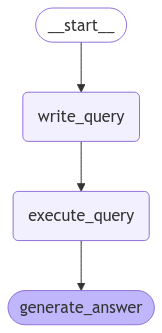

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application! Note that we can stream the results of individual steps:

In [14]:
for step in graph.stream(
    {"question": "what is Total amnount of money spent in july 2014?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT SUM(Total_Price) as Total_Spent FROM consumption WHERE Purchase_Date_Year = 2014 AND Purchase_Date_Month = 7;'}}
{'execute_query': {'result': '[(2465880295.540002,)]'}}
{'generate_answer': {'answer': 'The total amount of money spent in July 2014 is 2,465,880,295.54.'}}


# Finalizing the Application: Generating Answers

This section implements the final functionality of the application. Given a user question as a string, the application:
1. Processes the question to generate a SQL query.
2. Executes the query on the database.
3. Retrieves the result and generates a natural language answer.

### Function Overview:
- **Input:** A string representing the user question.
- **Process:** The application uses the LangGraph workflow to handle the input, execute a query, and interpret the result.
- **Output:** A natural language answer to the user’s question.

The implementation is wrapped in a function for reusability, allowing the app to handle various queries seamlessly. Below is the function definition and an example usage.


In [15]:
def get_answer(question: str) -> str:
    """
    Takes a user question as input and returns a natural language answer generated 
    by the application, which queries a SQL database to retrieve relevant data.

    Parameters:
    - question (str): The user question to be answered.

    Returns:
    - str: The generated natural language answer to the question.
    """
    # Use the LangGraph `graph.invoke` method to process the input question
    # The result is fetched in streaming mode to provide updates, and the final answer is extracted
    answer = graph.invoke({"question": question}, stream_mode="updates")[-1]["generate_answer"]["answer"]
    return answer

question = "what is Total number of orders in july 2014?"
print(get_answer(question))


The total number of orders in July 2014 is 11,839.


# Evaluation

In this step, we will evaluate the performance of the chatting assistant by testing it with a variety of sample queries. The goal is to ensure that the assistant provides accurate, relevant, and reliable responses based on the procurement data.

### Evaluation Process:
1. **Test with Sample Queries:**
   - We will input a range of questions related to procurement data, similar to the real-world use cases the assistant might encounter.
   - For each question, we will first run a Python function to generate the expected result, which will serve as the **ground truth**. Then, we will pass the same question through the assistant to get its generated response using the `get_answer` function.

2. **Performance Assessment:**
   -  We will compare the assistant’s answers to the expected results (ground truth) obtained from the Python functions. This comparison will help evaluate how accurately the assistant answers the questions.

By comparing the assistant’s responses against the expected outcomes, we will assess its ability to answer various types of procurement-related queries. This process ensures the assistant's reliability and effectiveness in providing meaningful insights from the dataset.


### Question 1: Total Number of Orders in a Specific Time Period

To evaluate the assistant's performance for this question, we will compare its response with the ground truth, generated using the `total_orders_in_time_period` Python function. This function calculates the number of orders within a given date range.


We'll use this function to get the expected result, then compare it with the assistant’s answer.


In [16]:
def total_orders_in_time_period(df, start_date, end_date):
    df['Creation_Date'] = pd.to_datetime(df['Creation_Date'])
    filtered_df = df[(df['Creation_Date'] >= start_date) & (df['Creation_Date'] <= end_date)]
    return len(filtered_df)

# Example Usage
start_date = '2013-07-01'
end_date = '2013-09-30'
print("Expected Output: ")
print(total_orders_in_time_period(df, start_date, end_date))  # Orders in Q1 of FY 2023-24
print("-*-"*20)
print("Assistant output: ")
print(get_answer("what is Total number of orders between '2013-07-01' and '2013-09-30'? consider only the date not the hours"))


Expected Output: 
28443
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The total number of orders between '2013-07-01' and '2013-09-30' is 28,443.


### Question 2: Identify the Quarter with the Highest Spending

To evaluate the assistant’s performance on this question, we will compare its response to the ground truth, which is calculated using the `highest_spending_quarter` Python function. This function identifies the quarter with the highest total spending from the procurement data.


In [17]:
def highest_spending_quarter(df):
    df['Creation_Date'] = pd.to_datetime(df['Creation_Date'])
    df['Fiscal Quarter'] = df['Creation_Date'].dt.to_period('Q')
    spending_by_quarter = df.groupby('Fiscal Quarter')['Total_Price'].sum()
    highest_quarter = spending_by_quarter.idxmax()
    highest_spending = spending_by_quarter.max()
    return highest_quarter, highest_spending

# Example Usage:
quarter, spending = highest_spending_quarter(df)
print("Expected Output: ")
print(f"Quarter with the highest spending: {quarter}, Amount: ${spending:.2f}")
print("-*-"*20)
print("Assistant output: ")
print(get_answer("what is the the quarter with the highest spending?"))

Expected Output: 
Quarter with the highest spending: 2015Q2, Amount: $28804820727.65
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The quarter with the highest spending is the second quarter of 2015 (2015Q2), with a total spending of 28,804,820,727.65.


### Question 3: Frequently Ordered Line Items

For this question, we will evaluate the assistant’s response by comparing it with the ground truth, which is obtained using the `frequently_ordered_items` Python function. This function identifies the most frequently ordered items from the procurement data.


In [18]:
def frequently_ordered_items(df, top_n=10):
    # Count the frequency of each item and return the top 10
    item_frequency = df['Item_Name'].value_counts().head(top_n)
    return item_frequency

# Example Usage
top_10_items = frequently_ordered_items(df, top_n=10)
print("Expected Output: ")
print(top_10_items)
print("-*-"*20)
print("Assistant output: ")
print(get_answer("what are the most 10 frequently ordered items?"))

Expected Output: 
Medical Supplies               2916
Contract                       2092
ew                             1539
Expert Witness                 1317
medical vocational training    1092
Toner                          1046
contract                        983
Office Supplies                 959
Dental Supplies                 772
toner                           658
Name: Item_Name, dtype: int64
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The most 10 frequently ordered items are:

1. Medical Supplies - 2916 orders
2. Contract - 2092 orders
3. ew - 1539 orders
4. Expert Witness - 1317 orders
5. Medical Vocational Training - 1092 orders
6. Toner - 1046 orders
7. Contract (lowercase) - 983 orders
8. Office Supplies - 959 orders
9. Dental Supplies - 772 orders
10. Toner (lowercase) - 658 orders


### Question 4: Total Amount Spent by Department in a Specific Fiscal Year

To evaluate the assistant’s performance for this question, we will compare its response with the ground truth, generated using the `total_spent_by_department` Python function. This function calculates the total amount spent by each department in a specified fiscal year.


In [19]:
def total_spent_by_department(df, fiscal_year, top_n=10):
    df['Fiscal_Year'] = df['Fiscal_Year'].astype(str)
    filtered_df = df[df['Fiscal_Year'] == fiscal_year]
    department_spending = filtered_df.groupby('Department_Name')['Total_Price'].sum()
    top_departments = department_spending.sort_values(ascending=False).head(top_n)
    return top_departments

# Example Usage:
fiscal_year = '2013-2014'
print("Expected Output: ")
print(total_spent_by_department(df, fiscal_year))  # Top 10 spending departments in FY 2013-2014
print("-*-"*20)
print("Assistant output: ") 
print(get_answer("what are the top 10 spending departments in fiscal year 2013-2014?"))

Expected Output: 
Department_Name
Health Care Services, Department of              2.845645e+10
Corrections and Rehabilitation, Department of    2.488082e+09
Transportation, Department of                    1.556413e+09
Water Resources, Department of                   1.168074e+09
Correctional Health Care Services                8.235272e+08
Social Services, Department of                   7.907241e+08
State Hospitals, Department of                   7.354055e+08
High Speed Rail Authority, California            7.261482e+08
Public Health, Department of                     5.923648e+08
Personnel Administration, Department of          3.716678e+08
Name: Total_Price, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The top 10 spending departments in fiscal year 2013-2014 are:

1. Health Care Services, Department of - $28,456,453,981.89
2. Corrections and Rehabilitation, Department of - $2,488,081,948.85
3. Transportation, Department of - $1,55

### Question 5: Items Purchased from Certified Suppliers

To evaluate the assistant’s performance for this question, we will compare its response with the ground truth, generated using the `items_from_certified_suppliers` Python function. This function retrieves items purchased from suppliers that meet specific certifications.


In [20]:
def orders_from_certified_suppliers(df, qualifications):
    # Filter the DataFrame for suppliers with specified qualifications
    filtered_df = df[df['Supplier_Qualifications'].str.contains(qualifications, na=False)]

    # Count the number of orders per supplier
    supplier_order_count = filtered_df.groupby('Supplier_Name').size().sort_values(ascending=False)

    return supplier_order_count.sort_values(ascending=False).head(10)
# Example Usage
qualifications = 'SB|SBE|DVBE'  # Small Business, Small Business Enterprise, Disabled Veteran Business Enterprise
print("Expected Output: ")
print(orders_from_certified_suppliers(df, qualifications))
print("-*-"*20)
print("Assistant output: ")
print(get_answer("How many orders were placed with certified suppliers, grouped by each supplier?"))

Expected Output: 
Supplier_Name
TAGG Industries, Inc.                                    3983
San Joaquin Distributors, Inc.                           3510
River City Office Supply                                 2643
THE PRIMARY SOURCE                                       2284
Horizon Business Solutions, Inc.                         2273
Merritt Business Supplies                                2169
Christian Bartels Enterprises Inc. dba CB Enterprises    2052
Bay Medical Co., Inc                                     1895
Adolph Inc.                                              1868
Office Xpress Inc                                        1817
dtype: int64
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The number of orders placed with certified suppliers, grouped by each supplier, are as follows:

1. TAGG Industries, Inc. - 3,983 orders
2. San Joaquin Distributors, Inc. - 3,510 orders
3. River City Office Supply - 2,643 orders
4. THE PRIMARY SOURCE - 2,

### Question 6: Most Expensive Supplier

For this question, we will evaluate the assistant’s response by comparing it with the ground truth, which is generated using the `most_expensive_supplier` Python function. This function identifies the supplier with the highest total spending.


In [21]:
def most_expensive_supplier(df):
    supplier_spending = df.groupby('Supplier_Name')['Total_Price'].sum()
    return supplier_spending.idxmax(), supplier_spending.max()

# Example Usage
supplier, spending = most_expensive_supplier(df)
print("Expected Output: ")
print(f"Most expensive supplier: {supplier}, Amount spent: ${spending:.2f}")
print("-*-"*20)
print("Assistant output: ")
print(get_answer("What is the most expensive supplier based on the total spent money?"))


Expected Output: 
Most expensive supplier: Health Net Community Solutions, Inc., Amount spent: $13587059000.06
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 


The most expensive supplier based on the total spent money is "Health Net Community Solutions, Inc." with a total spent amount of 13,587,059,000.06.


### Question 7: Total Orders by Month

For this question, we will evaluate the assistant’s response by comparing it with the ground truth, which is generated using the `total_orders_by_month` Python function. This function calculates the total number of orders placed in a specific month of a given year.


In [22]:
def total_orders_by_month(df, year, month):
    orders_in_month = df[(df['Purchase_Date_Year'] == year) & (df['Purchase_Date_Month'] == month)]
    return len(orders_in_month)

# Example Usage
year = 2013
month = 7  # July
print("Expected Output: ")
print(total_orders_by_month(df, year, month))
print("-*-"*20)
print("Assistant output: ")
print(get_answer("how many orders were placed in july 2013?"))


Expected Output: 
11391
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
A total of 11,391 orders were placed in July 2013.


### Question 8: Spending by Specific Month

For this question, we will evaluate the assistant’s response by comparing it with the ground truth, which is generated using the `spending_by_month` Python function. This function calculates the total spending in a specific month of a given year.


In [23]:
def spending_by_month(df, year, month):
    spending_in_month = df[(df['Purchase_Date_Year'] == year) & (df['Purchase_Date_Month'] == month)]['Total_Price'].sum()
    return spending_in_month

# Example Usage
year = 2013
month = 7  # July
print("Expected Output: ")
print(spending_by_month(df, year, month))
print("-*-"*20)
print("Assistant output: ")
print(get_answer("how much was spent in july 2013?"))


Expected Output: 
2220647365.84
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Assistant output: 
The total amount spent in July 2013 was 2,220,647,365.84.
